# Imports

In [1]:
import numpy as np
import healpy as hp
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from scipy.ndimage import gaussian_filter as gfilter
import pandas

import minot
from PerseusGammaCalibration import perseus_model_library

cosmo = FlatLambdaCDM(70, 0.3, Ob0=0.0224/0.674**2)

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

# Main parameters 

In [2]:
version = 3
use_psz_mass = False
Fx500_treshold = 1e-11 # erg/s/cm2
Nside = 256
Npt_per_decade = 30  # Set the precision
workdir = '/Users/adam/Project/CTA/Phys/Outputs/CTADC2022/'
do_validation = True

# Input catalog

In [3]:
#---------- Extract Accept info
accept = pandas.read_table('/Users/adam/Project/ExternalData/accept_main.tab', sep='\s+')
accept_name = []
accept_ra   = []
accept_dec  = []
accept_z    = []
accept_k0   = []
for icl in range(1, len(accept)):
    accept_coord_icl = SkyCoord(accept['RA'][icl]+accept['Dec'][icl], unit=(u.hourangle, u.deg), frame='icrs')
    accept_ra.append(accept_coord_icl.ra.to_value('deg'))
    accept_dec.append(accept_coord_icl.dec.to_value('deg'))
    accept_z.append(float(accept['z'][icl]))
    accept_k0.append(float(accept['K0'][icl]))
    accept_name.append(accept['#Name'][icl])
accept_name = np.array(accept_name)
accept_ra   = np.array(accept_ra)
accept_dec  = np.array(accept_dec)
accept_z    = np.array(accept_z)
accept_k0   = np.array(accept_k0)

#---------- Add info for important clusters (JPR sample)
accept_name = np.append(accept_name, 'A2634')
accept_ra = np.append(accept_ra, 354.57181275)
accept_dec = np.append(accept_dec, 27.02934221)
accept_z = np.append(accept_z, 0.031)
accept_k0 = np.append(accept_k0, 40.7) # https://www.aanda.org/articles/aa/pdf/2010/05/aa12377-09.pdf

accept_name = np.append(accept_name, 'A1367')
accept_ra = np.append(accept_ra, 176.12366417)
accept_dec = np.append(accept_dec, 19.83883798)
accept_z = np.append(accept_z, 0.022)
accept_k0 = np.append(accept_k0, 296.5) # https://www.aanda.org/articles/aa/pdf/2010/05/aa12377-09.pdf

accept_name = np.append(accept_name, 'A1656')
accept_ra = np.append(accept_ra, 194.95038236)
accept_dec = np.append(accept_dec, 27.97997795)
accept_z = np.append(accept_z, 0.023)
accept_k0 = np.append(accept_k0, 364.6) # https://www.aanda.org/articles/aa/pdf/2010/05/aa12377-09.pdf

accept_name = np.append(accept_name, 'NGC1399')
accept_ra = np.append(accept_ra, 54.6157681)
accept_dec = np.append(accept_dec, -35.45277218)
accept_z = np.append(accept_z, 0.005)
accept_k0 = np.append(accept_k0, 13.6)# https://www.aanda.org/articles/aa/pdf/2010/05/aa12377-09.pdf

accept_name = np.append(accept_name, 'Virgo')
accept_ra = np.append(accept_ra, 186.63483418)
accept_dec = np.append(accept_dec, 12.7233333)
accept_z = np.append(accept_z, 0.0036)
accept_k0 = np.append(accept_k0, 0) # No entropy floor seen? https://academic.oup.com/mnras/article/469/2/1476/3738101

#---------- Add info for relevant clusters (Fx500/1e-11 > 5)
accept_name = np.append(accept_name, '3C 129.1')
accept_ra = np.append(accept_ra, 72.515)
accept_dec = np.append(accept_dec, 45.024)
accept_z = np.append(accept_z, 0.022)
accept_k0 = np.append(accept_k0, np.nan) # https://academic.oup.com/mnras/article/326/1/2/1026382

accept_name = np.append(accept_name, 'RXC J1324.7-5736')
accept_ra = np.append(accept_ra, 201.18)
accept_dec = np.append(accept_dec, -57.614)
accept_z = np.append(accept_z, 0.019)
accept_k0 = np.append(accept_k0, 0) # clear CC cluster http://www.aspbooks.org/publications/329/183.pdf

accept_name = np.append(accept_name, 'A3627')
accept_ra = np.append(accept_ra, 243.594)
accept_dec = np.append(accept_dec, -60.869)
accept_z = np.append(accept_z, 0.0157)
accept_k0 = np.append(accept_k0, np.nan) # https://academic.oup.com/pasj/article/64/1/16/1432259 (merging + CC)

accept_name = np.append(accept_name, 'Triangulum Australis')
accept_ra = np.append(accept_ra, 249.567)
accept_dec = np.append(accept_dec, -64.347)
accept_z = np.append(accept_z, 0.0508)
accept_k0 = np.append(accept_k0, 1e4) # https://arxiv.org/pdf/astro-ph/9606112.pdf

In [4]:
#---------- Extract MCXC info
mcxc = fits.open('/Users/adam/Project/ExternalData/Planck/Clusters/MCXC_official.fits')
mcxc_data = mcxc[1].data

mcxc_ra    = []
mcxc_dec   = []
mcxc_z     = []
mcxc_m     = []
mcxc_Lx    = []
for icl in range(len(mcxc_data)):
    mcxc_ra.append(mcxc_data[icl][10])
    mcxc_dec.append(mcxc_data[icl][11])
    mcxc_z.append(mcxc_data[icl][14])
    mcxc_m.append(mcxc_data[icl][19])
    mcxc_Lx.append(mcxc_data[icl][18])
mcxc_ra    = np.array(mcxc_ra)
mcxc_dec   = np.array(mcxc_dec)
mcxc_z     = np.array(mcxc_z)
mcxc_m     = np.array(mcxc_m)
mcxc_Lx    = np.array(mcxc_Lx)

In [5]:
#---------- Extract PSZ2 info
psz2 = fits.open('/Users/adam/Project/ExternalData/Planck/Clusters/HFI_PCCS_SZ-union_R2.08.fits')
psz2_data = psz2[1].data

### Version 1: HIFLUGCS + Perseus

In [6]:
if version == 1:
    #---------- Start with HIFLUGCS (https://www.aanda.org/articles/aa/olm/2015/03/aa24085-14/aa24085-14.html)
    cat_name = np.array(['2A0335','A0085','A0119','A0133','A0262','A0399','A0400','A0401','A0478','A0496','A0576','A0754','A1060','A1367','A1644','A1650','A1651','A1656','A1736','A1795','A2029','A2052','A2063','A2065','A2142','A2147','A2163','A2199','A2204','A2255','A2256','A2589','A2597','A2634','A2657','A3112','A3158','A3266','A3376','A3391','A3395','A3526','A3558','A3562','A3571','A3581','A3667','A4038','A4059','EXO0422','HydraA','IIIZw54','MKW3S','MKW4','MKW8','NGC1399','NGC1550','NGC4636','NGC5044','NGC507','RXCJ1504','S1101','ZwCl1215', 'A2244', 'A0426'])
    cat_ra   = np.array([54.6714,10.4600,14.0668,15.6741,28.1926,44.4727,44.4233,44.7361,63.3548,68.4081,110.3761,137.3194,159.1781,176.2512,194.2991,194.6728,194.8423,194.8989,201.7161,207.2191,227.7336,229.1813,230.7713,230.6222,239.5860,240.5699,243.9445,247.1597,248.1956,258.1423,255.8094,350.9892,351.3330,354.6219,356.2395,49.4902,55.7178,67.8047,90.5360,96.5854,96.7073,192.2035,201.9870,203.4054,206.8680,211.8758,303.1778,356.9299,359.2539,66.4635,139.5254,55.3235,230.4656,181.1128,220.1795,54.6213,64.9082,190.7080,198.8495,20.9159,226.0313,348.4933,184.4238, 255.677375, 49.950667])
    cat_dec  = np.array([9.9672,-9.3031,-1.2557,-21.8822,36.1541,13.0313,6.0271,13.5777,10.4649,-13.2611,55.7641,-9.6891,-27.5283,19.6751,-17.4090,-1.7619,-4.1970,27.9597,-27.1741,26.5925,5.7448,7.0222,8.6075,27.7062,27.2303,15.9738,-6.1501,39.5503,5.5754,64.0699,78.6500,16.7772,-12.1243,27.0317,9.1919,-44.2384,-53.6321,-61.4531,-39.9468,-53.6936,-54.5427,-41.3122,-31.4953,-31.6714,-32.8660,-27.0196,-56.8468,-28.1420,-34.7593,-8.5605,-12.0958,15.3936,7.7080,1.8961,3.4660,-35.4502,2.4101,2.6868,-16.3852,33.2560,-2.8047,-42.7253,3.6551, 34.06037222, 41.511696])
    cat_z    = np.array([0.0349,0.0556,0.0440,0.0569,0.0161,0.0715,0.0240,0.0748,0.0848,0.0328,0.0381,0.0528,0.0114,0.0216,0.0474,0.0845,0.0860,0.0232,0.0461,0.0616,0.0767,0.0348,0.0354,0.0721,0.0899,0.0351,0.2010,0.0302,0.1523,0.0800,0.0601,0.0416,0.0852,0.0312,0.0404,0.0750,0.0590,0.0594,0.0455,0.0531,0.0498,0.0103,0.0480,0.0499,0.0374,0.0214,0.0560,0.0283,0.0460,0.0390,0.0538,0.0311,0.0450,0.0200,0.0270,0.0046,0.0123,0.0037,0.0090,0.0165,0.2153,0.0580,0.0750, 0.0967, 0.0179])
    
    #---------- mass from MCXC matching
    no_mass_count = 0
    cat_mass = cat_z*0
    for icl in range(len(cat_name)):
        dist = minot.ClusterTools.map_tools.greatcircle(mcxc_ra, mcxc_dec, cat_ra[icl], cat_dec[icl])
        c1 = (dist < 10.0/60)
        c2 = np.abs(mcxc_z - cat_z[icl]) < 0.1
        w    = c1*c2
        if np.sum(w) == 1: 
            cat_mass[icl] = mcxc_m[w][0]
        else:
            print('WARNING: Nmatch=', np.sum(w), str(i+1)+'/'+str(len(cat_name)), cat_name[icl])
            cat_mass[icl] = np.nan
    print('No mass for '+str(no_mass_count)+'/'+str(len(cat_name)))
        
    #---------- K0 from ACCEPT matching
    no_k0_count = 0
    cat_K0 = cat_mass*0
    for icl in range(len(cat_name)):
        dist = minot.ClusterTools.map_tools.greatcircle(accept_ra, accept_dec, cat_ra[icl], cat_dec[icl])
        c1 = (dist < 20.0/60)
        c2 = np.abs(accept_z - cat_z[icl]) < 0.1
        w    = c1*c2
        if np.sum(w) == 1: 
            cat_K0[icl] = accept_k0[w][0]
        else:
            print('WARNING: Nmatch=', np.sum(w), cat_name[icl])
            cat_K0[icl] = np.nan
            no_k0_count+=1
    print('No K0 for '+str(no_k0_count)+'/'+str(len(cat_name)))

### Version 2: MCXC threshold on F_X500 (i.e. mainly REFLEX/NORAS/CIZA)

In [7]:
if version == 2:
    cat_name = []
    cat_ra   = []
    cat_dec  = []
    cat_z    = []
    cat_mass = []
    cat_K0   = []
    cat_cat  = []

    #---------- Start with MCXC and treshold it
    no_k0_count = 0
    for icl in range(len(mcxc[1].data)):
        Dl = cosmo.luminosity_distance(mcxc[1].data[icl][14]).to_value('cm')
        if 1e44*mcxc[1].data[icl][18]**1.2/(4*np.pi*Dl**2) > Fx500_treshold: 
            cat_name.append(mcxc[1].data[icl][2])
            cat_ra.append(mcxc_data[icl][10])
            cat_dec.append(mcxc_data[icl][11])
            cat_z.append(mcxc_data[icl][14])
            cat_mass.append(mcxc_data[icl][19])
            cat_cat.append(mcxc_data[icl][16])

            #---------- Match to ACCEPT to get entropy
            dist = minot.ClusterTools.map_tools.greatcircle(accept_ra, accept_dec, 
                                                            mcxc[1].data[icl][10], mcxc_data[icl][11])
            c1 = (dist < 10.0/60)
            c2 = np.abs(accept_z - mcxc_data[icl][14]) < 0.1
            w    = c1*c2
            if np.sum(w) == 1: 
                cat_K0.append(accept_k0[w][0])
            else:
                print('     WARNING: Nmatch=', np.sum(w), 
                      1e44*mcxc[1].data[icl][18]**1.2/(4*np.pi*Dl**2)/Fx500_treshold, 
                      mcxc_data[icl][10], mcxc_data[icl][11], mcxc_data[icl][14],
                      mcxc[1].data[icl][1], mcxc[1].data[icl][2])
                cat_K0.append(np.nan)
                no_k0_count+=1
    print('No K0 for '+str(no_k0_count)+'/'+str(len(cat_name)))
    
    cat_name = np.array(cat_name)
    cat_ra   = np.array(cat_ra)
    cat_dec  = np.array(cat_dec)
    cat_z    = np.array(cat_z)
    cat_mass = np.array(cat_mass)
    cat_K0   = np.array(cat_K0)
    cat_cat  = np.array(cat_cat)

### Version 3: Judit DM based catalog

In [8]:
if version == 3:
    #---------- JPR inputs
    cat_name = np.array(['A0478','A0399','A2065','A1736','A1644','A0401','A2029','HydraA','ZwCl1215','MKW3s','A0133','A3158','A4059','A1795','A2657','A2147','A3376','A3562','A0085','A3391','A3667','A2052','2A0335','A2589','EXO0422','A0576','A2063','A3558','A2142','A0119','A2634','A2256','A0496','A3266','A1367','A4038','A0754','A2199','A3571','NGC5044','NGC5813','Ophiuchus','A1656','A0426','NGC5846','A1060','A3526','NGC1399','M49','NGC4636','Virgo'])
    cat_glon = np.array([182.41,164.37,42.880,312.58,304.91,164.18,6.5000,242.93,282.50,11.390,149.76,265.07,356.83,33.790,96.650,28.810,246.53,313.31,115.05,262.36,340.85,9.3900,176.25,94.660,203.30,161.42,12.850,311.98,44.230,125.70,103.45,111.10,209.59,272.09,234.80,24.890,239.25,62.900,316.32,311.23,359.18,0.5800,58.090,150.57,0.4300,269.63,302.41,236.72,286.92,297.75,279.68])
    cat_glat = np.array([-28.30,-39.47,+56.56,+35.10,+45.50,-38.87,+50.55,+25.09,+65.19,+49.45,-84.23,-48.97,-76.06,+77.16,-50.30,+44.49,-26.29,+30.35,-72.06,-25.26,-33.40,+50.10,-35.08,-41.20,-36.16,+26.24,+49.71,+30.74,+48.69,-64.10,-33.06,+31.74,-36.49,-40.17,+73.03,-75.82,+24.76,+43.70,+28.55,+46.10,+49.85,+9.290,+87.96,-13.26,+48.80,+26.51,+21.56,-53.64,+70.17,+65.47,+74.46])
    cat_z    = np.array([0.085,0.071,0.072,0.046,0.047,0.075,0.077,0.054,0.075,0.045,0.057,0.059,0.046,0.062,0.04,0.035,0.045,0.05,0.056,0.053,0.056,0.035,0.035,0.042,0.039,0.038,0.035,0.048,0.09,0.044,0.031,0.06,0.033,0.059,0.022,0.028,0.053,0.03,0.037,0.009,0.0064,0.028,0.023,0.0183,0.0061,0.011,0.01,0.005,0.0044,0.004,0.0036])
    cat_M200 = np.array([6.082,4.026,4.729,1.454,1.549,5.922,6.592,2.604,6.538,1.659,3.348,3.971,2.194,5.168,1.691,1.172,2.582,3.534,5.093,4.514,5.301,1.629,1.664,2.994,2.492,2.372,1.974,4.886,28.03,3.956,1.554,10.172,2.561,13.44,0.878,2.231,24.998,5.07,10.904,0.411,0.271,23.164,13.158,7.714,0.379,2.966,2.266,0.506,0.464,0.534,5.6])
    
    #---------- Get RA Dec
    cat_coord = SkyCoord(cat_glon, cat_glat, unit=u.deg, frame='galactic')
    cat_ra = cat_coord.icrs.ra.value
    cat_dec = cat_coord.icrs.dec.value

    #---------- Get M500
    cat_mass = cat_M200*0
    for icl in range(len(cat_name)): 
        cat_mass[icl] = minot.ClusterTools.cluster_global.Mdelta1_to_Mdelta2_NFW(cat_M200[icl], 
                                                                                 delta1=200, delta2=500, 
                                                                                 c1=5.0, redshift=cat_z[icl], 
                                                                                 cosmo=cosmo)
    #---------- Get K0
    no_k0_count = 0
    cat_K0 = cat_M200*0
    for icl in range(len(cat_name)):
        dist = minot.ClusterTools.map_tools.greatcircle(accept_ra, accept_dec, cat_ra[icl], cat_dec[icl])
        c1 = (dist < 20.0/60)
        c2 = np.abs(accept_z - cat_z[icl]) < 0.1
        w    = c1*c2
        if np.sum(w) == 1: 
            cat_K0[icl] = accept_k0[w][0]
        else:
            print('WARNING: Nmatch=', np.sum(w), cat_name[icl])
            cat_K0[icl] = np.nan
            no_k0_count+=1
    print('No K0 for '+str(no_k0_count)+'/'+str(len(cat_name)))

No K0 for 0/51


### Add Y and Lx info for validation

In [9]:
#---------- Lx500 from MCXC
no_Lx_count = 0
cat_Lx_mcxc = cat_z*0
cat_Lx_mod  = cat_z*0
for icl in range(len(cat_name)):
    dist = minot.ClusterTools.map_tools.greatcircle(mcxc_ra, mcxc_dec, cat_ra[icl], cat_dec[icl])
    c1 = (dist < 10.0/60)
    c2 = np.abs(mcxc_z - cat_z[icl]) < 0.1
    w    = c1*c2
    if np.sum(w) == 1: 
        cat_Lx_mcxc[icl] = mcxc_Lx[w][0]
    else:
        print('WARNING: Nmatch=', np.sum(w), str(icl+1)+'/'+str(len(cat_name)), cat_name[icl])
        cat_Lx_mcxc[icl] = np.nan
        no_Lx_count+=1
print('No Lx for '+str(no_Lx_count)+'/'+str(len(cat_name)))

No Lx for 3/51


In [10]:
#---------- Y500 from PSZ2
no_y_count = 0
cat_y_psz2 = cat_z*0
cat_yerr_psz2 = cat_z*0
cat_m_psz2 = cat_z*0
cat_merr_psz2 = cat_z*0
cat_y_mod  = cat_z*0
for icl in range(len(cat_name)):
    dist = minot.ClusterTools.map_tools.greatcircle(psz2_data['RA'], psz2_data['Dec'], cat_ra[icl], cat_dec[icl])
    c1 = (dist < 10.0/60)
    c2 = np.abs(psz2_data['redshift'] - cat_z[icl]) < 0.1
    w    = c1*c2
    if np.sum(w) == 1: 
        cat_y_psz2[icl] = psz2_data['Y5R500'][w][0]
        cat_m_psz2[icl] = psz2_data['MSZ'][w][0]
        cat_yerr_psz2[icl] = psz2_data['Y5R500_ERR'][w][0]
        cat_merr_psz2[icl] = (psz2_data['MSZ_ERR_LOW'][w][0]+psz2_data['MSZ_ERR_UP'][w][0])/2
    else:
        print('WARNING: Nmatch=', np.sum(w), str(icl+1)+'/'+str(len(cat_name)), cat_name[icl])
        cat_y_psz2[icl] = np.nan
        cat_m_psz2[icl] = np.nan      
        cat_yerr_psz2[icl] = np.nan
        cat_merr_psz2[icl] = np.nan
        no_y_count+=1
print('No Y for '+str(no_y_count)+'/'+str(len(cat_name)))

if use_psz_mass:
    cat_mass[cat_m_psz2/cat_m_psz2 == 1] = cat_m_psz2[cat_m_psz2/cat_m_psz2 == 1]

No Y for 18/51


# Compute sky maps looping over catalog

In [11]:
#---------- Energy bining definition
Ebin_emin = 100*u.GeV
Ebin_emax = 100*u.TeV
Ebin_nbin = 3

Ebin_pot    = np.logspace(np.log10(Ebin_emin.to_value('GeV')), 
                          np.log10(Ebin_emax.to_value('GeV')), 
                          Ebin_nbin+1)*u.GeV
Ebin_ctr    = ((Ebin_pot + np.roll(Ebin_pot,1))/2)[1:]
Ebin_logctr = 10**((np.log10(Ebin_pot.to_value('GeV')) + np.roll(np.log10(Ebin_pot.to_value('GeV')),1))/2)[1:]

Ebin_pot, Ebin_ctr, Ebin_logctr

(<Quantity [   100.,   1000.,  10000., 100000.] GeV>,
 <Quantity [  550.,  5500., 55000.] GeV>,
 array([  316.22776602,  3162.27766017, 31622.77660168]))

In [12]:
#---------- Helpix bining
skymap = np.zeros((Ebin_nbin, hp.nside2npix(Nside)))

In [13]:
#---------- Init the healpix to get lon and lat maps
bid_cl = minot.Cluster(silent=True)
bid_map, lon, lat = bid_cl.get_gamma_hpmap(nside=Nside, output_lonlat=True)

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/pixelfunc.py:528: RuntimeWarning: divide by zero encountered in _pix2ang_ring
  theta, phi = pixlib._pix2ang_ring(nside, ipix)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/pixelfunc.py:528: RuntimeWarning: invalid value encountered in _pix2ang_ring
  theta, phi = pixlib._pix2ang_ring(nside, ipix)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


In [14]:
cluster.set_density_gas_SVM_param?

Object `cluster.set_density_gas_SVM_param` not found.


In [15]:
K0_limits = [25, 70] # Used to define cool-cores, morphologically disturbed or universal clusters

for icl in range(len(cat_name)):
    print(str(icl+1)+'/'+str(len(cat_name)), cat_name[icl], cat_ra[icl], cat_dec[icl], cat_mass[icl], cat_z[icl])
    
    #---------- Special case for Perseus
    if cat_name[icl] == 'A0426': 
        cluster = perseus_model_library.default_model()
        cluster.output_dir = workdir
        cluster.Npt_per_decade_integ = Npt_per_decade
        cluster.R_truncation = 5*cluster.R500
        '''
        for ieb in range(Ebin_nbin):
            map_ebin = cluster.get_gamma_hpmap(nside=Nside, 
                                               Emin=Ebin_pot[ieb], Emax=Ebin_pot[ieb+1], 
                                               Rmin_los=1*u.kpc, NR500_los=3.0, Rmin=1*u.kpc, Rmax=3*cluster.R500, 
                                               Energy_density=False, Cframe=False, model='Kafexhiu2014', 
                                               maplonlat=[lon,lat], output_lonlat=False)
            skymap[ieb,:] += map_ebin.to_value('s-1 sr-1 cm-2')
        '''
    #---------- Otherwise build a standard model
    elif cat_mass[icl]/cat_mass[icl] == 1:
        # Init the model
        cluster = minot.Cluster(name=cat_name[icl], M500=cat_mass[icl]*1e14*u.Msun, redshift=cat_z[icl], 
                                RA=cat_ra[icl]*u.deg, Dec=cat_dec[icl]*u.deg, 
                                cosmology=cosmo, silent=True, output_dir=workdir)
        cluster.Npt_per_decade_integ = Npt_per_decade
        cluster.R_truncation = 5*cluster.R500
        
        # Select the thermodynamic profile using K0
        if cat_K0[icl] is np.nan:                                            # Undefined --> UPP
            cluster.set_pressure_gas_gNFW_param(pressure_model='A10UPP')
            cluster.set_density_gas_SVM_param(density_model='G19UDP')
        else:
            if cat_K0[icl] < K0_limits[0]:                                   # Low K0 --> CC
                cluster.set_pressure_gas_gNFW_param(pressure_model='A10CC')
                cluster.set_density_gas_SVM_param(density_model='G19CC')
            elif cat_K0[icl] >= K0_limits[0] and cat_K0[icl] < K0_limits[1]: # Intermediate K0 --> CC
                cluster.set_pressure_gas_gNFW_param(pressure_model='A10UPP')
                cluster.set_density_gas_SVM_param(density_model='G19UDP')
            else:                                                            # High K0 --> MD
                cluster.set_pressure_gas_gNFW_param(pressure_model='A10MD')
                cluster.set_density_gas_SVM_param(density_model='G19MD')
        
        #### Try polytropic expectation for density
        rad, prof = cluster.get_pressure_gas_profile(radius=np.logspace(-1,4,10000)*u.kpc)
        E_z   = cluster.cosmo.efunc(cluster.redshift)
        h70   = cluster.cosmo.H0.value/70.0
        mu_g,mu_e,mu_p,mu_a = minot.ClusterTools.cluster_global.mean_molecular_weight(Y=cluster.helium_mass_fraction,
                                                                                      Z=cluster.metallicity_sol*cluster.abundance)
        P500 = 3.426*1e-3 * (cluster.M500.to_value('Msun')*h70/1e15)**(2.0/3) * E_z**(8.0/3) * ((cluster.cosmo.Ob0/cluster.cosmo.Om0)/0.16)*(mu_g/0.6)*(mu_e/1.14)
        P0 = np.exp(-2.94)
        n0 = np.exp(-10.3)
        Gamma = 1.19
        profile = (prof.to_value('keV cm-3')/(P500*P0))**(1/Gamma) * n0*E_z**2 * u.cm**-3
        cluster.density_gas_model = {'name':'User', 'radius':rad, 'profile':profile}
        #### Try polytropic expectation for density
        
        # Set the CR
        cluster.X_cre1_E = {'X':0,    'R_norm':cluster.R500}
        cluster.X_crp_E  = {'X':0.01, 'R_norm':cluster.R500}
        cluster.set_density_crp_isodens_scal_param(scal=1.0)
        cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index': 2.2}
    
    #---------- Compute the sky map in each energy bin and sum
    for ieb in range(Ebin_nbin):
        map_ebin = cluster.get_gamma_hpmap(nside=Nside, 
                                           Emin=Ebin_pot[ieb], Emax=Ebin_pot[ieb+1], 
                                           Rmin_los=1*u.kpc, NR500_los=3.0, Rmin=1*u.kpc, Rmax=3*cluster.R500, 
                                           Energy_density=False, Cframe=False, model='Kafexhiu2014', 
                                           maplonlat=[lon,lat], output_lonlat=False)
        skymap[ieb,:] += map_ebin.to_value('s-1 sr-1 cm-2')
        
    if do_validation:
        #---------- Check the model with Y comparison
        cat_y_mod[icl] = 1e3*(cluster.get_sz_flux(Compton_only=True, 
                                                  Rmin=1*u.kpc, Rmin_los=1*u.kpc,
                                                  Rmax=cluster.R_truncation)[0]/cluster.D_ang**2).to_value('')*(60*180/np.pi)**2
        #---------- Check the model with Lx comparison
        cluster.make_xspec_table(Emin=0.1*u.keV, Emax=2.4*u.keV, 
                                 Tmin=0.1*u.keV,Tmax=30.0*u.keV, nbin=30, 
                                 nH=0*u.cm**-2, app_nH_model=False)
        cat_Lx_mod[icl] = 1e-44*(cluster.get_xray_flux(Rmax=cluster.R500, Rmin=1*u.kpc, Rmin_los=1*u.kpc, Cframe=True,
                                                       type_integral='spherical', output_type='S')*4*np.pi*cluster.D_lum**2).to_value('erg s-1')

1/51 A0478 63.33269008092375 10.47439690608991 3.9426776016097427 0.085


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


2/51 A0399 44.48449778125335 13.014163186617187 2.6098684682803044 0.071


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


3/51 A2065 230.67900247687086 27.724980255400116 3.065590657351604 0.072


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


4/51 A1736 201.72051247391224 -27.10685190710357 0.9425605446794746 0.046


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


5/51 A1644 194.31188056294968 -17.349433229341958 1.004144624283704 0.047


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


6/51 A0401 44.736320727186595 13.581294669762167 3.838957046486829 0.075


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


7/51 A2029 227.74021474606937 5.76086768455832 4.2732868710640295 0.077


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


8/51 HydraA 139.52382797219056 -12.100447449106287 1.688052034625415 0.054


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


9/51 ZwCl1215 184.41887653141546 3.6662584432152414 4.238281183710042 0.075


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


10/51 MKW3s 230.46387210551052 7.702298798845464 1.0754525059307065 0.045


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


11/51 A0133 15.66350154341443 -21.951955157510497 2.1703526159469613 0.057


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


12/51 A3158 55.66226847266776 -53.63234223230151 2.574214527456803 0.059


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


13/51 A4059 359.16916023345027 -34.67256651678901 1.4222681121229486 0.046


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


14/51 A1795 207.2469338546964 26.586192406376643 3.3501739304701013 0.062


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


15/51 A2657 356.21223218424416 9.142729347505913 1.0961966169552897 0.04


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


16/51 A2147 240.57573027298162 15.897123686649634 0.7597530662753393 0.035


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


17/51 A3376 90.18368068159904 -40.053895094443504 1.6737904582960135 0.045


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


18/51 A3562 203.38414317265784 -31.67196336315837 2.2909277612773478 0.05


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


19/51 A0085 10.406074870872555 -9.338598628494038 3.301554920256232 0.056


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


20/51 A3391 96.40550549038943 -53.70359063109353 2.9262161614051903 0.053


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


21/51 A3667 303.1426431427353 -56.841366843040554 3.4363916419160194 0.056


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


22/51 A2052 229.19204434474452 6.9955925976244275 1.056004901845161 0.035


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


23/51 2A0335 54.644435383314445 9.96325142573183 1.0786937732782975 0.035


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


24/51 A2589 351.00074918690666 16.822449364571497 1.9408708877375151 0.042


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


25/51 EXO0422 66.46538421497519 -8.558719964276472 1.6154476460393734 0.039


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


26/51 A0576 110.34595472393606 55.735249859319346 1.5376572296971909 0.038


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


27/51 A2063 230.7613524098926 8.63877736673012 1.2796523488289426 0.035


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


28/51 A3558 201.97993500983145 -31.489985418083325 3.1673664520659646 0.048


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


29/51 A2142 239.58202521452725 27.23317100752652 18.170544750595376 0.09


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


30/51 A0119 14.068486965229184 -1.2542473681912754 2.5644907254140326 0.044


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


31/51 A2634 354.57181275482225 27.029342208308158 1.0073858916312952 0.031


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


32/51 A2256 255.91340167530987 78.71944370279823 6.5940342919392165 0.06


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


33/51 A0496 68.40685262180352 -13.264984456842225 1.6601771354361308 0.033


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


34/51 A3266 67.79783145802591 -61.40608229587585 8.712526630324714 0.059


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


35/51 A1367 176.12366416945284 19.838837980026103 0.569166546236987 0.022


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


36/51 A4038 356.88343891265646 -28.202604248573966 1.4462534904951216 0.028


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


37/51 A0754 137.21155319767055 -9.632716554539275 16.205040231016167 0.053


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


38/51 A2199 247.15002486833544 39.526625329561206 3.2866450904573132 0.03


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


39/51 A3571 206.87188204810792 -32.86042416604186 7.068555831626537 0.037


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


40/51 NGC5044 198.8469108739858 -16.385511528937702 0.2664321759719834 0.009


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ebltable/tau_from_model.py:307: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ebltable/tau_from_model.py:307: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon

41/51 NGC5813 225.29489716609402 1.7020422649157998 0.17567669023943447 0.0064


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ebltable/tau_from_model.py:307: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ebltable/tau_from_model.py:307: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon

42/51 Ophiuchus 258.1016904607801 -23.352822147921078 15.016143367919767 0.028


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


43/51 A1656 194.95038236497385 27.979977953873703 8.52971915192058 0.023


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


44/51 A0426 49.94525281866656 41.51583292963367 5.000627263863456 0.0183


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


45/51 NGC5846 226.6212126705961 1.6098527965853926 0.2456880649474007 0.0061


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ebltable/tau_from_model.py:307: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ebltable/tau_from_model.py:307: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon

46/51 A1060 159.2160880895042 -27.522814296612776 1.9227197905910056 0.011


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


47/51 A3526 192.21326126182873 -41.309128072255135 1.4689423619282587 0.01


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


48/51 NGC1399 54.61576810438894 -35.452772183411355 0.328016255576213 0.005


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ebltable/tau_from_model.py:307: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ebltable/tau_from_model.py:307: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon

49/51 M49 187.43772049229705 7.97535894910335 0.30078960985644876 0.0044


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ebltable/tau_from_model.py:307: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ebltable/tau_from_model.py:307: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon

50/51 NGC4636 190.70816514486296 2.6848698156981334 0.346167352722723 0.004


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ebltable/tau_from_model.py:307: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ebltable/tau_from_model.py:307: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon

51/51 Virgo 186.63483417699504 12.72333329896005 3.630219429301962 0.0036


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ebltable/tau_from_model.py:307: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ebltable/tau_from_model.py:307: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  newcm.set_over(newcm(1.0))
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  newcm.set_under(bgcolor)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colo

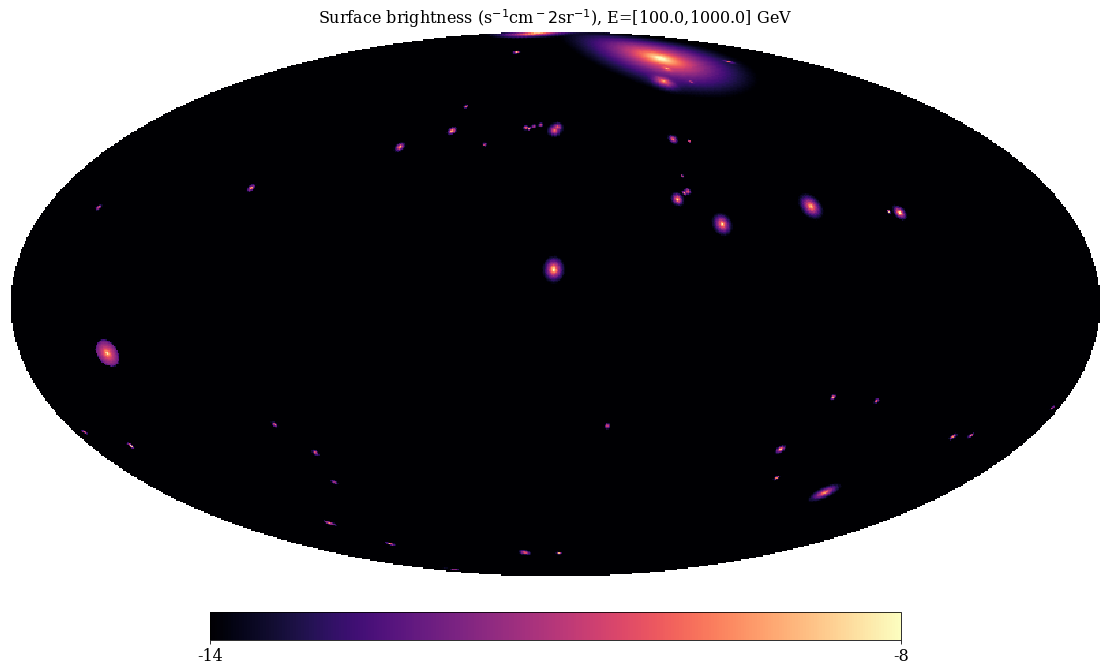

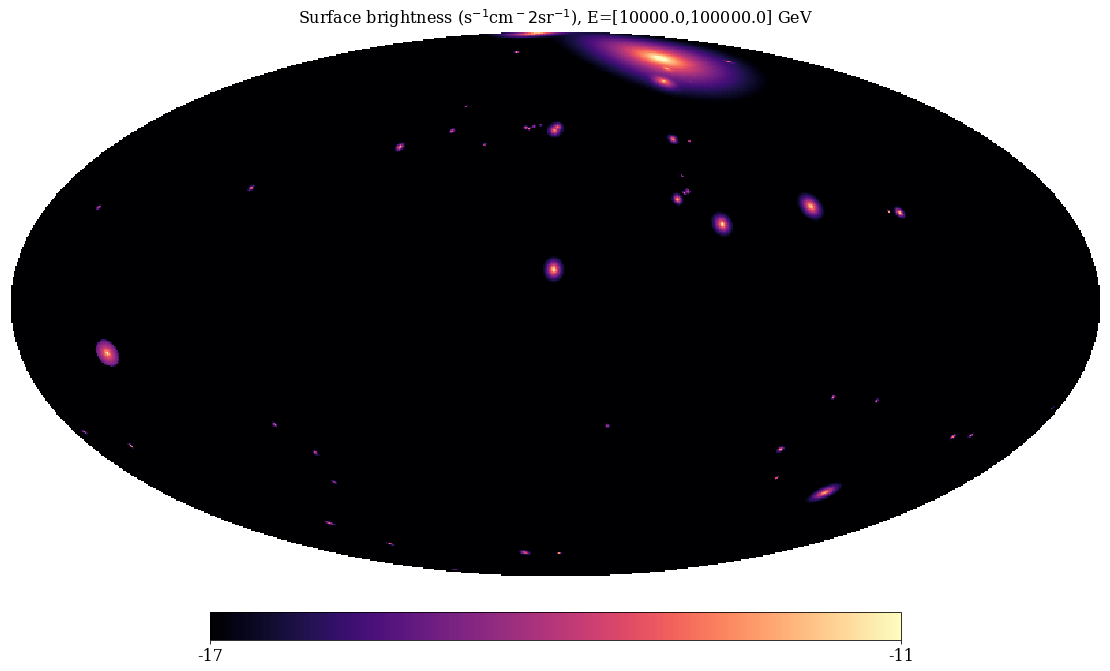

In [16]:
#---------- Show the first and last energy bins
skymap_show = skymap[0,:]
skymap_show[skymap_show<=1e-16] = 1e-16
skymap_show = np.log10(skymap_show)
fig = plt.figure(0, figsize=(20,10))
hp.mollview(skymap_show, 
            #min=np.amax(skymap_show)-6, max=np.amax(skymap_show)-1, 
            min=-14, max=-8, 
            cmap='magma', fig=0,
            title='Surface brightness (s$^{-1}$cm$^-2$sr$^{-1}$), E=['+str(Ebin_pot[0].to_value('GeV'))+','+str(Ebin_pot[0+1].to_value('GeV'))+'] GeV')
fig.savefig(workdir+'skymap_FirstEbin_V'+str(version)+'_PSZmass'+str(use_psz_mass)+'.pdf')

skymap_show = skymap[Ebin_nbin-1,:]
skymap_show[skymap_show<=1e-20] = 1e-20
skymap_show = np.log10(skymap_show)
fig = plt.figure(1, figsize=(20,10))
hp.mollview(skymap_show, 
            #min=np.amax(skymap_show)-6, max=np.amax(skymap_show)-1,
            min=-17, max=-11,
            cmap='magma', fig=1, 
            title='Surface brightness (s$^{-1}$cm$^-2$sr$^{-1}$), E=['+str(Ebin_pot[Ebin_nbin-1].to_value('GeV'))+','+str(Ebin_pot[Ebin_nbin].to_value('GeV'))+'] GeV')
fig.savefig(workdir+'skymap_LastEbin_V'+str(version)+'_PSZmass'+str(use_psz_mass)+'.pdf')

In [17]:
#---------- Save the maps as fits files
filename = workdir+'cluster_sky_map_V'+str(version)+'_PSZmass'+str(use_psz_mass)+'.fits'

column_names = []
for ieb in range(Ebin_nbin):
    column_names.append('Gamma-ray in E=['+str(Ebin_pot[ieb].to_value('GeV'))+','+str(Ebin_pot[ieb+1].to_value('GeV'))+'] GeV')

hp.write_map(filename, skymap, overwrite=True, fits_IDL=False,
             column_names=column_names,
             column_units='s-1 sr-1 cm-2')

Ebin_hdr = fits.Header()
Ebin_hdr.add_comment('Energy bin edges (GeV)')
fits.append(filename, Ebin_pot.to_value('GeV'), Ebin_hdr)

# Validation with Perseus

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
85.76508819532087 94.23491180467911 -4.234911804679125 4.234911804679125
The interval between parallels is 1 deg 0.00'.
The interval between meridians is 1 deg 0.00'.


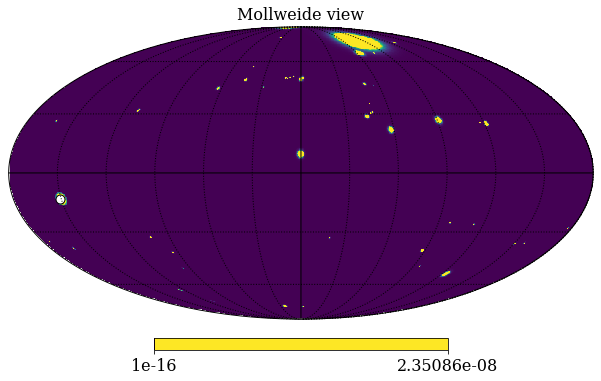

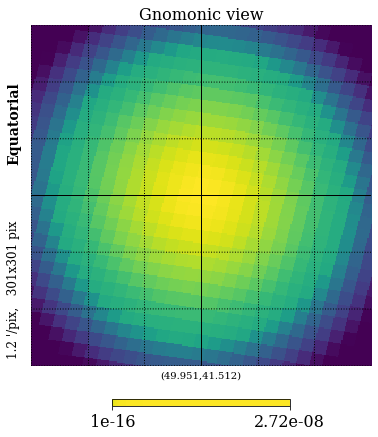

In [18]:
#---------- Get the Perseus definition
perseus = perseus_model_library.default_model()
perseus.output_dir = workdir
perseus.cosmo = cosmo
perseus.Npt_per_decade_integ = Npt_per_decade
perseus.R_truncation = 5*perseus.R500
perseus.map_reso = 0.02*u.deg
perseus.map_fov  = 6*u.deg

#---------- Extract Perseus (first energy bin) from the healpix map
gmap_hp, gheader = minot.ClusterTools.map_tools.roi_extract_healpix(filename, perseus.coord.ra.value, perseus.coord.dec.value, 
                                                 perseus.map_reso.to_value('deg'), 
                                                 [perseus.map_fov[0].to_value('deg'), perseus.map_fov[1].to_value('deg')],
                                                 visu=True)
#---------- Set match the headers
perseus.map_header = gheader

In [19]:
#---------- Compute
sigma_smooth = 0
perseus_map = perseus.get_gamma_map(Emin=Ebin_pot[0], Emax=Ebin_pot[0+1],
                                    Rmin_los=1*u.kpc, NR500_los=3.0, Rmin=1*u.kpc, Rmax=3*perseus.R500, 
                                    Energy_density=False, Cframe=False, model='Kafexhiu2014')
gmap_hp_filt     = gfilter(gmap_hp, sigma=sigma_smooth)
perseus_map_filt = gfilter(perseus_map.to_value('s-1 sr-1 cm-2'), sigma=sigma_smooth)

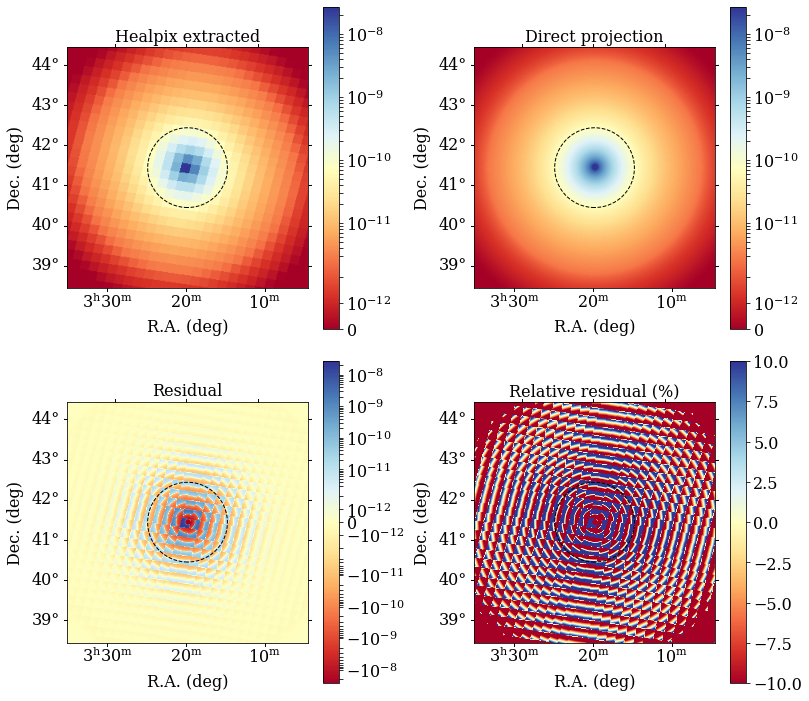

In [20]:
#---------- Show the maps and difference
rad = perseus.theta500.to_value('deg')

fig = plt.figure(0, figsize=(12, 10))
ax = plt.subplot(221, projection=WCS(gheader))
plt.imshow(gmap_hp_filt, 
           norm=SymLogNorm(np.amax(gmap_hp_filt)/1e4, vmin=0, vmax=np.amax(gmap_hp_filt), base=10), 
           origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((perseus.coord.ra.value, perseus.coord.dec.value),2*rad/np.cos(perseus.coord.dec.value*np.pi/180), 2*rad,linewidth=1, fill=False, zorder=2,edgecolor='black', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
plt.colorbar()
plt.title('Healpix extracted')

ax = plt.subplot(222, projection=WCS(gheader))
plt.imshow(perseus_map_filt, 
           norm=SymLogNorm(np.amax(gmap_hp_filt)/1e4, vmin=0, vmax=np.amax(gmap_hp_filt), base=10), 
           origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((perseus.coord.ra.value, perseus.coord.dec.value),2*rad/np.cos(perseus.coord.dec.value*np.pi/180), 2*rad,linewidth=1, fill=False, zorder=2,edgecolor='black', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
plt.colorbar()
plt.title('Direct projection')

ax = plt.subplot(223, projection=WCS(gheader))
plt.imshow(gmap_hp_filt - perseus_map_filt, 
           norm=SymLogNorm(np.amax(gmap_hp_filt)/1e4, vmin=-np.amax(gmap_hp_filt), vmax=np.amax(gmap_hp_filt), base=10), 
           origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((perseus.coord.ra.value, perseus.coord.dec.value),2*rad/np.cos(perseus.coord.dec.value*np.pi/180), 2*rad,linewidth=1, fill=False, zorder=2,edgecolor='black', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
plt.colorbar()
plt.title('Residual')

ax = plt.subplot(224, projection=WCS(gheader))
plt.imshow((gmap_hp_filt - perseus_map_filt)/perseus_map_filt*100, vmin=-10, vmax=10, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((perseus.coord.ra.value, perseus.coord.dec.value),2*rad/np.cos(perseus.coord.dec.value*np.pi/180), 2*rad,linewidth=1, fill=False, zorder=2,edgecolor='black', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
plt.colorbar()
plt.title('Relative residual (%)')

plt.subplots_adjust(left=None, bottom=0.05, right=None, top=0.99, wspace=0.35, hspace=0.10)
plt.savefig(workdir+'Validation_Projection_Perseus.pdf')

# Scaling relation and model

In [21]:
import matplotlib
import matplotlib.pyplot as plt

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


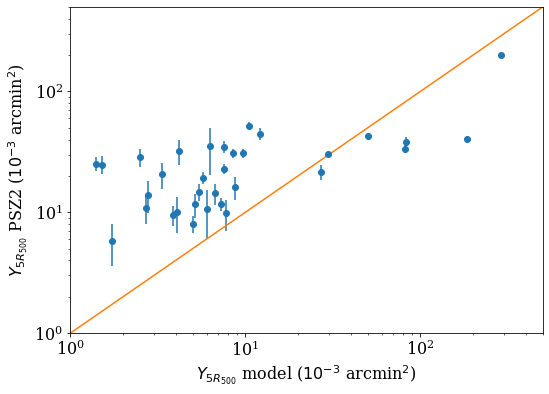

In [22]:
if do_validation:
    plt.errorbar(cat_y_mod, cat_y_psz2, yerr=cat_yerr_psz2, marker='o', ls='')
    plt.errorbar(cat_y_mod[cat_name == 'A0426'], cat_y_psz2[cat_name == 'A0426'], yerr=cat_yerr_psz2[cat_name == 'A0426'], color='red', marker='s', ls='', label='Perseus')
    plt.plot(np.linspace(0.1,1000),np.linspace(0.1,1000))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1,500)
    plt.ylim(1,500)
    plt.xlabel('$Y_{5 R_{500}}$ model ($10^{-3}$ arcmin$^2$)')
    plt.ylabel('$Y_{5 R_{500}}$ PSZ2 ($10^{-3}$ arcmin$^2$)')
    plt.savefig(workdir+'Validation_Y5R500_V'+str(version)+'_PSZmass'+str(use_psz_mass)+'.pdf')

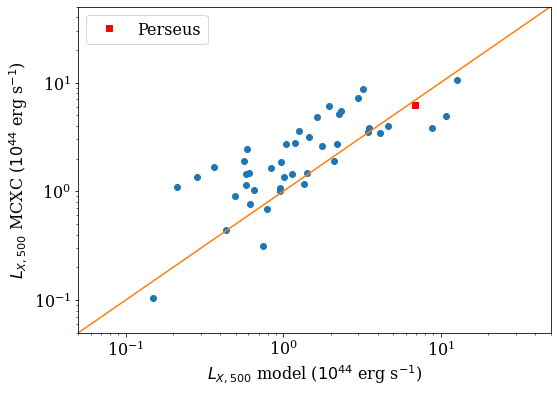

In [23]:
if do_validation:
    plt.plot(cat_Lx_mod, cat_Lx_mcxc, marker='o', ls='')
    plt.plot(cat_Lx_mod[cat_name == 'A0426'], cat_Lx_mcxc[cat_name == 'A0426'], color='red', marker='s', ls='', label='Perseus')
    plt.plot(np.linspace(0.01,50),np.linspace(0.01,50))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.05,50)
    plt.ylim(0.05,50)
    plt.xlabel('$L_{X,500}$ model ($10^{44}$ erg s$^{-1}$)')
    plt.ylabel('$L_{X,500}$ MCXC ($10^{44}$ erg s$^{-1}$)')
    plt.legend()
    plt.savefig(workdir+'Validation_Lx500_V'+str(version)+'_PSZmass'+str(use_psz_mass)+'.pdf')

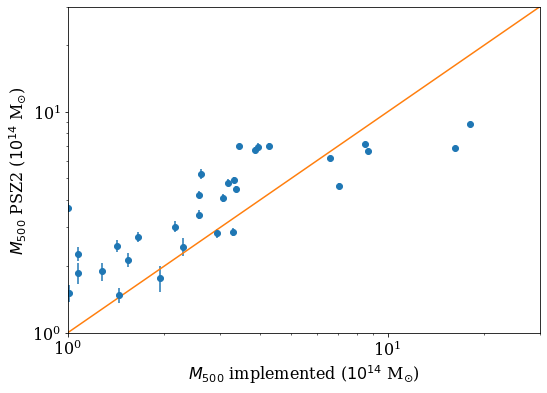

In [24]:
if do_validation:
    plt.errorbar(cat_mass, cat_m_psz2, yerr=cat_merr_psz2, marker='o', ls='')
    plt.plot(np.linspace(1,50),np.linspace(1,50))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1,30)
    plt.ylim(1,30)
    plt.xlabel('$M_{500}$ implemented ($10^{14}$ M$_{\odot}$)')
    plt.ylabel('$M_{500}$ PSZ2 ($10^{14}$ M$_{\odot}$)')
    plt.savefig(workdir+'Validation_M500_PSZ2_MCXC_V'+str(version)+'_PSZmass'+str(use_psz_mass)+'.pdf')